In [4]:
import pandas as pd
import numpy as np

from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold

#classifiers
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Prformance metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
# from nested_cv import NestedCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from statistics import mean

#Explainable AI
import shap

In [2]:
from sklearn.exceptions import ConvergenceWarning
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

simplefilter(action='ignore', category=ConvergenceWarning)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize']=15,10

In [6]:
yps = pd.read_excel('ypsML.xlsx')

In [7]:
yps_c = yps.drop([124, 125, 126, 63, 191])
yps_c = yps_c.drop(['FGF5', 'CD6', 'FGF5.1','CD6.1','BNPT','KIR3DL1','PGF.1',
                    'placental growth factor.1','VEGFC','Unnamed: 0','sample_id'], axis=1)
percent_missing = yps_c.isnull().sum() * 100 / len(yps_c)
missing_value_df = pd.DataFrame({'column_name': yps_c.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df['percent_missing']> 0.000] 

,column_name,percent_missing


In [ ]:
yps_c

,LGALS9,TNFRSF10A,AGRP,TNFRSF10B,TNFRSF13B,FIGF,DKK1,REN,PDGFB,GH1,CD4,PIGR,AMBP,SOD2,HSPB1,IL6,LPL,THBD,DCN,CTSL,MMP7,CXCL1,HMOX1,PARP1,CCL3,FABP2,V-SRC,F3,NPPB,IL1RN,FST,KITLG,TGM2,BMP6,IL4R,F2R,PTX3,GIF,CD40LG,Fcgr2b,...,ST3GAL1,FOXO1,PTPRJ,BAMBI,PTK7,PDCD1,PON2,SMAD1,MAEA,VASH1,RRM2B,DSG4,GALNT10,SERPINA3,PLXDC1,ENAH,CLEC11A,BANK1,HAVCR1.1,ERBB2IP,AMN,LAT2,CLSPN,C12orf5,PDGFC,SIRT5,PDP1,EGFL7,RCOR1,CA14,STX8,PRKAB1,MAP4K5,NUB1,ENTPD2,MAGED1,GPR56,Age cat,KIDNEY,WHO max
0,11.081702,4.604910,4.984198,6.960417,10.182863,7.614558,9.851886,10.057523,10.977739,6.988514,6.612681,7.570633,9.284846,9.854501,11.151508,4.427611,11.089259,11.024236,6.041164,7.988285,10.975333,8.676253,12.931195,3.593733,3.450821,7.884254,7.757723,7.607968,2.538248,7.889974,11.392240,10.492269,10.076052,5.827081,3.442897,10.045474,3.890700,7.132993,6.103441,2.776825,...,4.976415,3.119403,1.881678,2.403143,3.164302,2.007996,1.805908,0.546041,1.154794,-0.906607,0.630418,3.028955,1.585740,2.963588,0.868246,1.789102,3.689247,8.316982,10.330270,4.274811,4.779476,4.219203,0.867647,1.907247,3.892508,-1.875100,1.316857,5.866308,1.761019,1.932889,3.021332,1.346193,4.887906,0.734646,1.184821,0.273853,4.203050,3,0.0,0
1,11.009022,4.894731,4.796938,7.349588,10.332330,7.836224,10.224069,9.608952,11.579386,7.660335,6.873412,7.507458,9.195243,9.889487,11.126152,4.919027,11.308485,11.333606,6.275467,8.114713,10.974339,9.691674,13.186263,3.206044,4.053834,9.297633,8.170635,7.958657,2.703082,7.899856,11.794763,10.947087,8.762710,6.090495,4.041032,10.287391,4.004002,7.618573,6.561113,2.622389,...,5.333095,4.310477,1.921239,2.740456,3.409491,2.168104,2.072887,0.879743,0.829707,0.158654,0.761776,3.590215,2.100329,2.890615,1.218653,2.168690,4.119726,9.333416,10.991281,4.879487,4.694594,4.698892,0.833561,2.303923,4.025834,-1.702421,1.187098,6.458168,1.742502,2.297966,3.330722,1.792149,5.670321,1.012858,1.156164,0.570002,4.652802,3,0.0,0
2,11.196057,3.518154,5.803616,6.833773,9.932770,7.264155,10.481463,8.592953,11.348308,9.380038,5.918811,7.239157,8.743328,9.875996,10.943690,13.342836,9.234714,10.402933,5.523143,10.206389,10.068427,9.725526,13.708659,5.080335,4.411080,8.887387,8.163291,6.880982,2.311696,7.057108,12.010284,9.616079,8.272463,6.125248,2.875047,9.930854,5.931013,6.079110,8.340954,3.673627,...,5.433231,4.116556,3.486529,1.391334,1.766266,1.390254,3.276772,2.712624,1.544732,0.832953,2.448450,2.196144,2.246377,2.083252,0.728453,2.248750,3.484936,9.647269,7.801227,5.609672,5.140761,6.052904,1.539680,3.467595,4.368470,-2.078378,2.197948,5.271563,2.885611,1.428140,3.637663,1.906845,7.462180,2.787872,0.857860,0.850148,1.468622,1,0.0,1
3,11.130491,3.857390,4.834083,7.498931,10.427790,8.376554,9.613088,8.519257,10.469849,7.982250,6.402789,7.382997,8.950580,9.296807,11.306867,12.166620,9.925618,11.468479,5.981843,10.464232,10.484962,9.267582,13.960573,7.705489,6.061829,6.569330,8.118140,7.360194,1.684277,6.164722,11.399122,9.278327,8.983846,5.904951,3.707928,9.902280,4.800377,4.639195,6.514308,4.008194,...,4.926602,3.715083,2.247753,1.747040,2.734372,2.048768,3.808454,2.430419,1.249617,-0.040271,3.419486,3.214698,2.804271,4.967372,0.822665,3.883045,3.840347,9.269648,11.346330,5.080972,5.839772,5.276346,1.362589,3.680660,4.725076,-1.607597,1.293522,5.377077,8.048116,2.461547,3.625101,2.406798,6.783666,1.758431,3.151743,0.503991,1.547771,1,0.0,1
4,10.961490,4.541551,5.319961,7.298032,10.070917,6.883523,10.690591,10.338206,11.519099,10.181140,6.432237,7.421778,8.604266,9.965361,10.941055,12.037777,9.539420,10.284015,5.988816,9.304919,9.834694,9.664627,13.536364,4.046811,4.688289,8.377590,8.104366,7.459297,2.377664,7.763654,12.117604,8.171147,9.380743,5.542655,4.046888,10.293431,6.254785,5.332857,8.160511,3.036191,...,5.248038,4.593501,2.145399,1.203748,2.550203,1.473448,2.449718,2.413940,0.866431,1.009306,1.873251,1.133347,1.840964,1.943566,0.363719,1.447574,3.338999,9.971701,8.705931,4.919304,2.982993,5.244167,1.259642,2.297924,4.456185,-1.942209,1.508539,6.023410,2.440307,

In [ ]:
def Algo_search(models , params):

    max_score = 0
    max_model = None
    max_model_params = None
    estimators_gridsearch = pd.DataFrame()
    models_est = []
    parametres = []
    lscore = []
    lroc = []
    lfscore = []
    lprecision = []
    lrecall = []
    
    scoring = {'accuracy': make_scorer(accuracy_score), 
               'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
               'f1': make_scorer(f1_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score),}

    for i,j in zip(models.keys() , models.values() ):

        gs = GridSearchCV(estimator=j,param_grid=params[i], scoring=scoring, refit = "accuracy", )
        a = gs.fit(X_train,y_train)
        score = gs.score(X_test,y_test, )
        mauc = []
        mprecision = []
        mrecall = []
        mfscore = []
        maccuracy = []
        for i in range(5):
          maccuracy.append(mean(gs.cv_results_['split'+str(i)+'_test_accuracy']))
          mauc.append(mean(gs.cv_results_['split'+str(i)+'_test_roc_auc']))
          mfscore.append(mean(gs.cv_results_['split'+str(i)+'_test_f1']))
          mprecision.append(mean(gs.cv_results_['split'+str(i)+'_test_precision']))
          mrecall.append(mean(gs.cv_results_['split'+str(i)+'_test_recall']))
        models_est.append(gs.best_estimator_)
        parametres.append(gs.best_params_)
        lscore.append(round(score,2))
        lroc.append(round(mean(mauc),2))
        lfscore.append(round(mean(mfscore),2))
        lprecision.append(round(mean(mprecision),2))
        lrecall.append(round(mean(mrecall),2))

        if score > max_score:
            max_score = score
            max_model = gs.best_estimator_
            max_model_params = gs.best_params_

    estimators_gridsearch['Models'] = list(models_est)
    estimators_gridsearch['Best parameters'] = list(parametres)
    estimators_gridsearch['Score'] = list(lscore)
    estimators_gridsearch['AUC'] = list(lroc)
    estimators_gridsearch['F1-score'] = list(lfscore)
    estimators_gridsearch['Precision'] = list(lprecision)
    estimators_gridsearch['Recall'] = list(lrecall)
   

    # print(estimators_gridsearch)

    return [max_score, max_model, max_model_params], estimators_gridsearch

In [ ]:
#Data points

models = {'model_gbm':GradientBoostingClassifier(), 'model_rf':RandomForestClassifier(), 
  'model_dt':DecisionTreeClassifier(), 'model_svm':SVC(), 'model_ada':AdaBoostClassifier(), 'model_knn': KNeighborsClassifier(), 
  'model_xgb': xgb.XGBClassifier(),'model_ext': ExtraTreesClassifier(), 'model_mlp': MLPClassifier()}
params_gbm = {'learning_rate':[0.1,0.2,0.3,0.4], 'n_estimators':[50,100,500,1000,2000]}
params_rf = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
params_dt = {'splitter':['best','random'], 'max_depth':[1, 5, 10, 50, 100]}
params_svm = {'C':[1,2,5,10,50,100,500], 'kernel':['rbf','poly','sigmoid','linear']}
params_ada = {'n_estimators':[10,20,30,50,100,500,1000], 'learning_rate':[0.5,1,2,5,10]}
params_knn = {'n_neighbors' : [2,5,10,25,50]}
params_xgb = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
params_ext = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
model_mlp = {'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 
             'learning_rate':['constant','adaptive'], 'alpha': [0.0001, 0.05],
             'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]}
params = {'model_gbm':params_gbm, 'model_rf':params_rf, 'model_dt':params_dt, 'model_svm':params_svm, 'model_ada':params_ada, 'model_knn': params_knn,
          'model_xgb':params_xgb, 'model_ext':params_ext, 'model_mlp': model_mlp}

In [8]:
from sklearn.preprocessing import StandardScaler

col = yps_c.drop(['WHO max', 'KIDNEY', 'Age cat'], axis=1).columns

sc = StandardScaler()

for i in col:
    yps_c[[i]] = sc.fit_transform(yps_c[[i]])

In [9]:
X = yps_c.drop(['WHO max'], axis=1)
y = yps_c['WHO max']

# PCA preprocessing

In [10]:
pca = PCA(.90)

X = pca.fit_transform(X[col])
X = pd.DataFrame(X)
X['KIDNEY'] = list(yps_c['KIDNEY'])
X['Age cat'] = list(yps_c['Age cat'])

In [11]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=yps_c.drop(['WHO max'], axis=1)[col].columns)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
LGALS9,0.206889,0.755553,0.267091,-0.311329,-0.016484,-0.063109,-0.024131,-0.117083,-0.159736,-0.178181,...,-0.009547,-0.041434,0.048980,0.011677,-0.024945,0.048582,0.008697,0.027394,0.026188,-0.027450
TNFRSF10A,0.355664,0.815127,0.150443,-0.024916,-0.076468,-0.069260,-0.017062,-0.014899,-0.060321,0.003297,...,0.035053,0.007879,-0.027613,0.004582,-0.052029,0.025678,-0.076724,0.012537,-0.024469,0.027810
AGRP,-0.110215,0.730362,-0.208760,-0.154085,-0.053045,-0.088165,0.149405,-0.007218,-0.117974,0.105837,...,0.041878,-0.011675,-0.028071,-0.017327,-0.011360,-0.072771,-0.010923,-0.063706,0.035656,-0.035565
TNFRSF10B,0.348554,0.838572,0.161134,0.153952,-0.192117,-0.020343,-0.105196,-0.028737,-0.042941,-0.033069,...,-0.000933,0.006656,-0.016396,-0.001710,0.004605,0.002863,-0.016870,-0.013250,0.008024,0.037493
TNFRSF13B,0.121346,0.400674,-0.071025,0.001511,-0.029458,-0.036530,0.241434,-0.379414,-0.076405,-0.092000,...,-0.049990,-0.011993,-0.025879,-0.006878,-0.069608,0.104305,0.007698,-0.004856,-0.111985,-0.025929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAP4K5,-0.937493,0.062145,0.092647,-0.100380,-0.118226,-0.024902,-0.010003,-0.018885,-0.052581,0.078102,...,0.007406,-0.028861,-0.021012,0.021861,-0.028138,0.021721,0.024329,0.029775,-0.047360,-0.000713
NUB1,-0.943695,0.023083,0.228558,0.092374,-0.067601,-0.041173,0.030625,0.007106,-0.021031,-0.007460,...,0.000513,0.028581,-0.000565,0.019473,-0.024623,-0.001942,0.001903,-0.007274,-0.001808,0.000580
ENTPD2,-0.109354,0.483282,-0.204909,-0.075216,0.180773,0.461823,-0.081973,0.137192,0.007988,-0.078299,...,-0.029852,-0.015290,0.060378,0.041977,0.009340,-0.020289,-0.035097,0.019258,-0.067542,0.021909
MAGED1,-0.709049,0.410562,0.303801,-0.088053,0.029453,-0.031091,0.029509,-0.136514,-0.057224,-0.129310,...,0.014914,-0.019968,0.053375,-0.030671,0.016683,0.051088,-0.043791,-0.004916,-0.026823,0.029041


In [13]:
load_trans = loading_matrix.T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowYPS.xlsx')

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params)

grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.3, 'n_estimators': 2000}",0.90,0.90,0.67,0.80,0.60
1,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'class_weight': None, 'max_depth': 10, 'n_est...",0.88,0.94,0.54,1.00,0.40
2,"DecisionTreeClassifier(max_depth=10, splitter=...","{'max_depth': 10, 'splitter': 'random'}",0.86,0.72,0.56,0.60,0.52
3,SVC(C=2),"{'C': 2, 'kernel': 'rbf'}",1.00,0.98,0.83,0.97,0.72
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 1, 'n_estimators': 500}",0.94,0.92,0.66,0.91,0.57
5,KNeighborsClassifier(),{'n_neighbors': 5},0.90,0.92,0.63,0.97,0.50
6,"(ExtraTreeClassifier(max_depth=5, random_state...","{'class_weight': {0: 1, 1: 5}, 'max_depth': 5,...",0.98,0.95,0.68,0.97,0.55
7,"MLPClassifier(hidden_layer_sizes=(50, 50, 50))","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.94,0.98,0.79,0.84,0.75
8,"XGBClassifier(learning_rate=0.25, max_depth=5,...","{'gamma': 0, 'learning_rate': 0.25, 'max_depth...",0.90,0.93,0.75,0.97,0.65


# Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'relu',
hidden_layer_sizes= (50, 50, 50),
alpha= 0.0001,
learning_rate= 'constant',
solver= 'adam'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test)

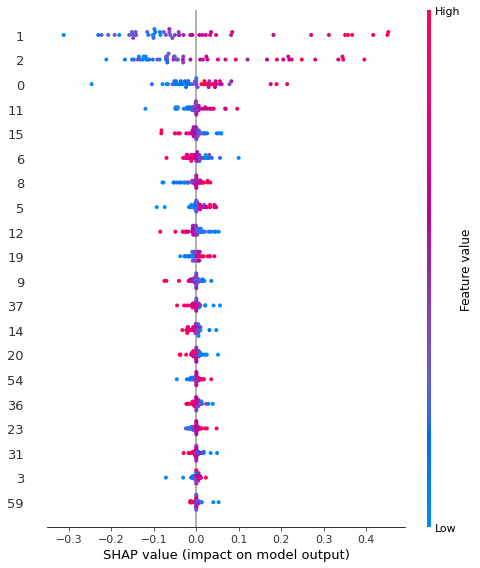

In [15]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_yps.svg')

In [16]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('yps_mlp_xai.xlsx')

In [17]:
load_trans = loading_matrix[list(feature_importance['col_name'])[:21]].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowYPSmpl.xlsx')